# Calculating evolution of MLTAN and RAAN

## MLTAN

The Mean Local Time of the Ascending Node (MLTAN) of an orbit is defined as the angle between the orbit's ascending node and the mean Sun. The MLTAN is often presented in units of time with 12:00 PM - or noon - describing a Sun-synchronous orbit that places the Sun directly at zenith when the spacecraft is at the ascending node. 

**MLTAN and MLTDN of selected satellites (as of 2018):**

| CATNR | Satellite   | MLTAN | MLTDN |
| ----- | ----------- | ----- | ----- |
| 39084 | LANDSAT 8   | 22:00 | 10:00 |
| 25682 | LANDSAT 7   | 22:00 | 10:00 |
| 39227 | KOMPSAT 5   | 06:00 | 18:00 |
| 29268 | KOMPSAT 2   | 10:40 | 22:40 |
| 35681 | DEIMOS 1    | 10:00 | 22:00 |
| 37849 | SUOMI NPP   | 13:20 | 01:20 |
| 40299 | HODOYOSHI 1 | 11:00 | 23:00 |
| 42835 | WNI-SAT 1R  | 11:00 | 23:00 |

## RAAN

The Right Ascension of the Ascending Node (RAAN) is the angle from a reference direction, called the origin of longitude, to the direction of the ascending node. The reference direction is the First Point of Aries, the location of the vernal equinox. The inclination is typically reported in degrees.

In [1]:
import os
from skyfield.api import load
from ground_path import ground_path, ltan_raan
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import pandas as pd
import multiprocessing

In [2]:
satellite = load.tle('http://celestrak.com/satcat/tle.php?CATNR=40299', filename='tle_hodoyoshi_1.txt')['HODOYOSHI 1'] # MLTAN 11:00 MLTDN 23:00
print(satellite)

EarthSatellite 'HODOYOSHI 1' number=40299 epoch=2018-10-24T12:03:08Z


In [3]:
np.rad2deg(satellite.model.inclo), np.rad2deg(satellite.model.nodeo), satellite.model.no

(97.3704, 16.9494, 0.06650074387028093)

## Generate ground paths

In [4]:
%%time
# to get a well distributed sample of LTAN and RAAN
# lets generate ground path with interval of 30 seconds, every 5 days during 4 years
major_period = ('2018-01-01', '2022-01-01')
major_freq = '5D'
minor_freq = 30

dates = pd.date_range(major_period[0], major_period[1], freq=major_freq)

# use multiprocessing to speed up ground path generation
p = multiprocessing.Pool(multiprocessing.cpu_count())

tasks = []
for date in dates:
    date_from = date
    date_to = date_from + timedelta(days=1)
    tasks.append((satellite, date_from, date_to, minor_freq))

dfs = p.starmap(ground_path, tasks)
p.close()
p.join()

CPU times: user 239 ms, sys: 64.9 ms, total: 304 ms
Wall time: 2min 4s


In [5]:
dfs[0].head()

,X,Y,Z,lat,lon,elevation,ascending,orbit
datetime,,,,,,,,
2018-01-01 00:00:00+00:00,-719.772345,1953.951246,-6570.188568,-72.552804,9.561631,533.581166,False,0
2018-01-01 00:00:30+00:00,-695.121724,2170.560796,-6504.537235,-70.832344,6.995457,533.207233,False,0
2018-01-01 00:01:00+00:00,-669.713167,2384.803710,-6431.773975,-69.084326,4.819851,532.783791,False,0
2018-01-01 00:01:30+00:00,-643.574274,2596.446032,-6351.977372,-67.314958,2.948685,532.312451,False,0
2018-01-01 00:02:00+00:00,-616.733443,2805.256527,-6265.233608,-65.528710,1.318415,531.794975,False,0


### Get LTAN and RAAN for one period

In [6]:
df = dfs[0]
df_ltan = ltan_raan(df)
df_ltan.head()

,X,Y,Z,lat,lon,elevation,ascending,orbit,local_time,raan
datetime,,,,,,,,,,
2018-01-01 00:20:00+00:00,534.011397,6857.573311,214.930310,1.806403,-19.832844,503.575766,True,1,23:00:40.117448,85.547262
2018-01-01 01:54:30+00:00,518.875382,6860.403627,157.221284,1.322514,-43.395853,503.668663,True,2,23:00:54.995280,85.674762
2018-01-01 03:29:00+00:00,503.697308,6862.716848,99.503061,0.838653,-66.958890,503.764077,True,3,23:01:09.866336,85.802235
2018-01-01 05:03:30+00:00,488.479336,6864.512805,41.779184,0.354816,-90.521946,503.862005,True,4,23:01:24.733001,85.929688
2018-01-01 06:38:30+00:00,502.545983,6859.960155,210.399809,1.768008,-114.454115,503.444020,True,5,23:00:41.012393,85.810119


**Observe**

- Ascending nodes are not laying exactly on the equator because ground path is calculated  with a big interval (30 seconds).
Decreasing interval will improve accuracy of LTAN calculation.

### Calculate Mean LTAN and RAAN

In [7]:
columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
df_ltan_stats = pd.DataFrame([], columns=columns, index=dates)
df_raan_stats = pd.DataFrame([], columns=columns, index=dates)

for i, date in enumerate(dates):
    df = dfs[i]
    df_ltan = ltan_raan(df)
    
    raan_stats = df_ltan['raan'].describe()
    df_raan_stats.loc[date, columns] = raan_stats

    lt_stats = (df_ltan['local_time'].dt.total_seconds() / 3600).describe()
    df_ltan_stats.loc[date, columns] = lt_stats

In [8]:
df_ltan_stats.head()

,count,mean,std,min,25%,50%,75%,max
2018-01-01,16,23.0177,0.00477742,23.0111,23.0144,23.0177,23.021,23.0243
2018-01-06,16,23.0178,0.00469615,23.0115,23.0146,23.0177,23.021,23.0242
2018-01-11,16,23.0169,0.00468381,23.0106,23.0138,23.0169,23.02,23.0232
2018-01-16,15,23.0146,0.00458501,23.0087,23.0109,23.0131,23.0172,23.0212
2018-01-21,15,23.0125,0.00458028,23.006,23.01,23.0141,23.0162,23.0183


In [9]:
df_raan_stats.head()

,count,mean,std,min,25%,50%,75%,max
2018-01-01,16,86.1327,0.337265,85.5473,85.8998,86.1327,86.3656,86.7181
2018-01-06,16,91.0566,0.316522,90.5344,90.7946,91.0548,91.315,91.5751
2018-01-11,16,95.9655,0.308713,95.5066,95.7361,95.9655,96.1949,96.4243
2018-01-16,15,100.886,0.306916,100.343,100.664,100.864,101.121,101.378
2018-01-21,15,105.777,0.306082,105.285,105.542,105.799,105.998,106.318


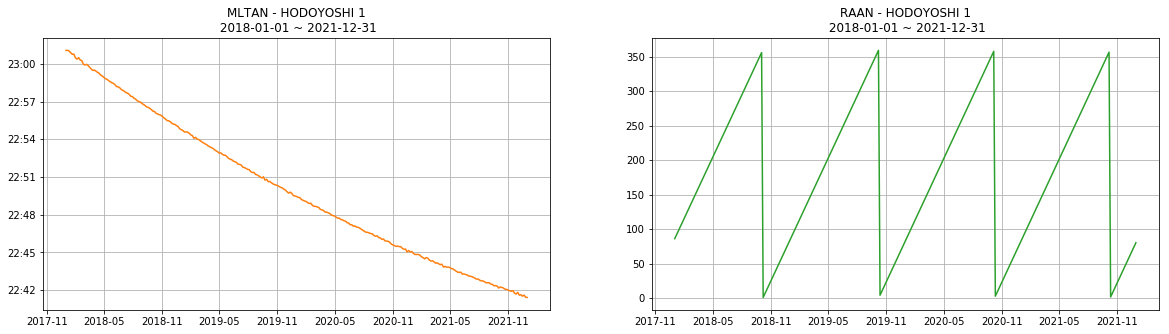

In [10]:
import matplotlib.ticker as tick

fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].plot(df_ltan_stats['mean'], 'C1')
ax[0].set_title("MLTAN - {}\n {:%Y-%m-%d} ~ {:%Y-%m-%d}".format(satellite.name, df_ltan_stats.index[0], df_ltan_stats.index[-1]))
frm = tick.FuncFormatter(lambda x, y: '{:02d}:{:02d}'.format(int(np.floor(x)), int((x % 1) * 60)))
ax[0].yaxis.set_major_formatter(frm)
ax[0].grid()

ax[1].plot(df_raan_stats['mean'], 'C2')
ax[1].set_title("RAAN - {}\n {:%Y-%m-%d} ~ {:%Y-%m-%d}".format(satellite.name, df_raan_stats.index[0], df_raan_stats.index[-1]))
ax[1].grid()

plt.savefig('mltan_raan_evolution_hodoyoshi_1.jpg')
plt.show()

## Sources

- http://www.celestrak.com/NORAD/elements/
- https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20150010230.pdf
- http://cires1.colorado.edu/events/lidarworkshop/LWG/Jun09/Papers.jun09/Kavaya2.jun09.pdf
- https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20080012667.pdf
- http://rhodesmill.org/skyfield/positions.html#barycentric-position
- http://issfd.org/2015/files/downloads/papers/107_Mazzoleni.pdf
- https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20080012667.pdf
- https://arc.aiaa.org/doi/abs/10.2514/6.2015-4488
- https://space.stackexchange.com/questions/22125/how-local-time-of-a-sun-synchronous-orbit-is-related-to-right-ascension-of-ascen
- https://www.yumpu.com/en/document/view/36384921/mean-local-time-of-the-ascending-node-orbital-and-celestial-
- MLTAN of existing satellites
    - https://earthi.space/wp-content/uploads/2018/03/Earth-i-Tech-Spec-for-KOMPSAT.pdf
    - https://satellitesafety.gsfc.nasa.gov/missions.html
    - http://www.remss.com/support/crossing-times/